# HY2B SWH对比

In [1]:
from HaiYangData import *
import glob

In [2]:
# 设置空间分辨率
years = ['2019']
months = ['04']
time_window = 1800

In [3]:
# 将WGS 84坐标（4326）转化为极射投影
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

transformer = HaiYangData.set_transformer(crs,crs2)
transformer_back = HaiYangData.set_transformer(crs2,crs)

In [7]:
hy_alt = HaiYangData(satellite='hy', sensor='alt',resolution=25000)


In [13]:
hyfiles = []
hy_value = ['swh_ku','swh_c','rain_flag','ice_flag','surface_type']
hy_fill_value = 32767
for yea in years:
    for mon in months:
        hy_dir_path = r'G:\\remote_sensing_data\\hy2b\\ALT\\'+ yea + '\\' + mon
        hyfiles = hyfiles + (glob.glob(hy_dir_path + '\*.nc'))
hyfiles.sort()


In [61]:

hy_ori_df = pd.DataFrame(np.column_stack((hy_alt.alt_from_nc_files(hyfiles, value=hy_value))), columns=['lon', 'lat', 'time']+hy_value)

# 删除无效点,只处理北纬66°以上的数据


KeyboardInterrupt: 

In [75]:
hy_df = hy_ori_df.drop(list(np.where(hy_ori_df['swh_ku'] == hy_fill_value)[0][:]))
hy_df = hy_alt.data_filter(hy_df,'lat',66)

In [78]:
hy_df = hy_df.drop(hy_df[(hy_df.rain_flag != 0)].index)

In [76]:
hy_df = hy_df.drop(hy_df[(hy_df.ice_flag != 0)].index)

In [81]:
hy_df = hy_df.drop(hy_df[(hy_df.surface_type == 2)].index)

In [138]:
hy_df.to_csv('hy' +str( years) + str(months) + '.csv')

In [5]:

# hy_df = pd.read_csv(r"/home/hanlu/python_workfile/remote_sensing/hy['2019', '2020']['04', '05', '06', '07', '08', '09'].csv")

CPU times: user 332 ms, sys: 84.5 ms, total: 416 ms
Wall time: 414 ms


In [58]:
hy_df_temp = hy_ori_df.drop(list(np.where(hy_ori_df['swh_ku'] == hy_fill_value)[0][:]))
hy_df_temp = hy_alt.data_filter(hy_df_temp,'lat',66)

In [59]:
# 将投影数据添加到dataframe中
hy_alt.add_proj(hy_df_temp, transformer)

# 交叉点平均化
hy_mean_grid = hy_alt.coincident_point_mean(hy_df_temp,'swh_ku')

# 获得XYmgrid
hy_x_map, hy_y_map = hy_alt.get_map_grid(transformer_back)

In [83]:
# 将投影数据添加到dataframe中
hy_alt.add_proj(hy_df, transformer)

# 交叉点平均化
hy_mean_grid = hy_alt.coincident_point_mean(hy_df,'swh_ku')

# 获得XYmgrid
hy_x_map, hy_y_map = hy_alt.get_map_grid(transformer_back)

<ipython-input-84-1e5fcfe383a5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(hy_x_map, hy_y_map, data=hy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)


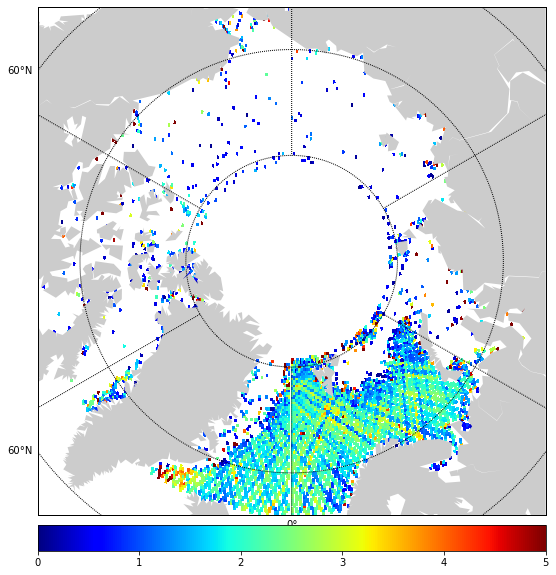

In [84]:
plt.figure(figsize=(10, 10))
hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')
hy_m.pcolormesh(hy_x_map, hy_y_map, data=hy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
hy_m.colorbar(location='bottom')
hy_m.fillcontinents() 
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
# plt.title("HY2B SWH  "+ year+ month)
plt.show()
plt.close()

<ipython-input-60-1e5fcfe383a5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  hy_m.pcolormesh(hy_x_map, hy_y_map, data=hy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)


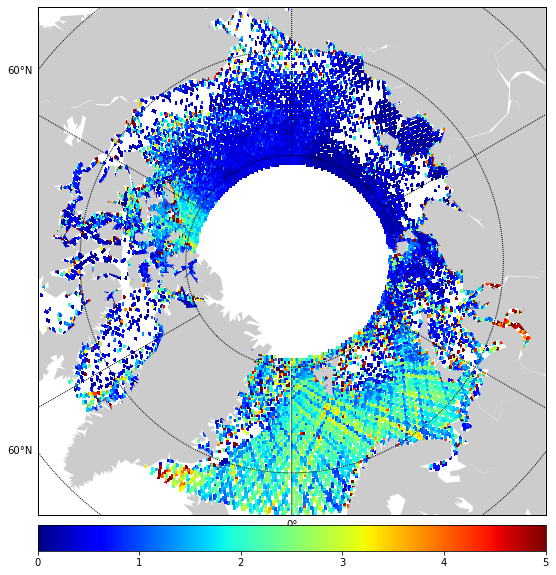

In [60]:
plt.figure(figsize=(10, 10))
hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')
hy_m.pcolormesh(hy_x_map, hy_y_map, data=hy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
hy_m.colorbar(location='bottom')
hy_m.fillcontinents() 
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
# plt.title("HY2B SWH  "+ year+ month)
plt.show()
plt.close()

# Cryosat 数据处理

In [87]:
cyfiles = []
cy_fill_value = -32768

for yea in years:
    for mon in months:
        cy_dir_path = r'G:\\remote_sensing_data\\cryosat2\\LRM_L2\\'+yea + '\\' + mon
        cyfiles = cyfiles + (glob.glob(cy_dir_path + '\*.nc'))
cyfiles.sort()

In [89]:
cy_siral = HaiYangData(satellite='cy', sensor='siral',resolution=25000)

In [90]:

cy_value = ['swh_ocean_01_ku','surf_type_20_ku']

cy_ori_df = pd.DataFrame(np.column_stack((cy_siral.cy_siral_from_nc(cyfiles, value=cy_value))), columns=['lon', 'lat', 'time']+cy_value)

# 删除无效点,只处理北纬66°以上的数据
cy_df = cy_ori_df.drop(list(np.where(cy_ori_df['swh_ocean_01_ku'] == cy_fill_value)[0][:]))
cy_df = cy_siral.data_filter(cy_df,'lat',66)

In [137]:
cy_df.to_csv('cy' +str( years) + str(months) + '.csv')

In [11]:

# cy_df = pd.read_csv(r"/home/hanlu/python_workfile/remote_sensing/cy['2019', '2020']['04', '05', '06', '07', '08', '09'].csv")

CPU times: user 98 ms, sys: 16.1 ms, total: 114 ms
Wall time: 113 ms


In [91]:
# 将投影数据添加到dataframe中
cy_siral.add_proj(cy_df, transformer)

# 交叉点平均化
cy_mean_grid = cy_siral.coincident_point_mean(cy_df,'swh_ocean_01_ku')

# 获得XYmgrid
cy_x_map, cy_y_map = cy_siral.get_map_grid(transformer_back)

<ipython-input-92-83a174753b7c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cy_m.pcolormesh(cy_x_map, cy_y_map, data=cy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)


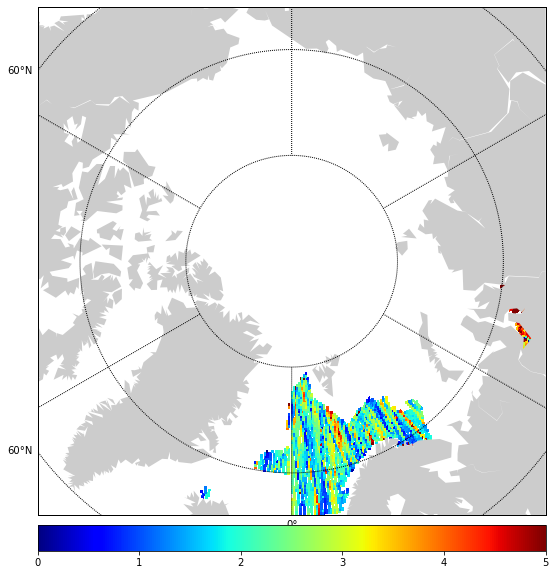

In [92]:
plt.figure(figsize=(10, 10))
cy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')
cy_m.pcolormesh(cy_x_map, cy_y_map, data=cy_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
cy_m.colorbar(location='bottom')
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
# plt.title("cy2 SWH  "+ year+ month)
plt.show()
plt.close()

# ICESAT2 数据处理

In [12]:

# icesat2 的时间是从2018-01-01 00：00：00开始记的，Hy2b和cryosat2的是从2000-01-01 00：00：00开始计的
# 2018-01-01 00：00：00 与2000-01-01 00：00：00 相差了568080000秒
correction_second = 568080000
is_fill_value = 32767
isfiles = []
is_value = ['swh']
for yea in years:
    for mon in months:
        is_dir_path = r'G:\\remote_sensing_data\\icesat2\\'+yea + '\\' + mon
        isfiles = isfiles + (glob.glob(is_dir_path + '\\*.h5'))
isfiles.sort()

In [9]:
is_atlas = HaiYangData(satellite='is', sensor='atlas',resolution=25000)

In [13]:

is_value = ['swh']

is_ori_df = pd.DataFrame(np.column_stack((is_atlas.is_atlas_from_nc(isfiles, value=is_value))), columns=['lon', 'lat', 'time','prc_land','prc_ocean','prc_sea_ice','prc_land_ice','prc_inland_water',]+is_value)

In [26]:
is_df = is_df.drop(is_df[(is_df.lat < 66)].index)

In [16]:
# 删除无效点,只处理北纬66°以上的数据
is_df = is_ori_df.drop(list(np.where(is_ori_df['swh'] == is_fill_value)[0][:]))
is_df = is_atlas.data_filter(is_df,'lat',66)

In [33]:
is_ori_df.head()

,lon,lat,time,prc_land,prc_ocean,prc_sea_ice,prc_land_ice,prc_inland_water,swh
0,38.801747,17.667108,6.074096e+08,100.0,100.0,0.0,0.0,100.0,1.528353
1,38.794956,17.732595,6.074096e+08,100.0,100.0,0.0,0.0,100.0,1.486058
2,38.788468,17.795155,6.074096e+08,100.0,100.0,0.0,0.0,100.0,1.307805
3,38.782350,17.854136,6.074096e+08,100.0,100.0,0.0,0.0,100.0,1.467084
4,38.774958,17.925394,6.074096e+08,100.0,100.0,0.0,0.0,100.0,1.616698


In [34]:
is_df.to_csv('is' +str( years) + str(months) + '.csv')

In [18]:

# is_df = pd.read_csv(r"/home/hanlu/python_workfile/remote_sensing/is['2019', '2020']['04', '05', '06', '07', '08', '09'].csv")

CPU times: user 11.1 s, sys: 2.47 s, total: 13.5 s
Wall time: 14.1 s


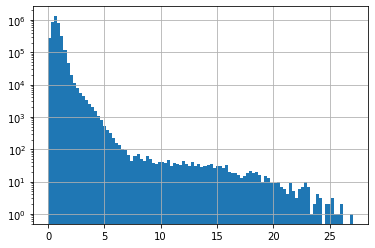

In [30]:
fig,ax = plt.subplots()
is_df.swh.hist(ax=ax,bins=100)
ax.set_yscale('log')

In [31]:
# 将投影数据添加到dataframe中
is_atlas.add_proj(is_df, transformer)

# 交叉点平均化
is_mean_grid = is_atlas.coincident_point_mean(is_df,'swh')

# 获得XYmgrid
is_x_map, is_y_map = is_atlas.get_map_grid(transformer_back)

<ipython-input-32-adb2b6d25290>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  is_m.pcolormesh(is_x_map, is_y_map, data=is_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)


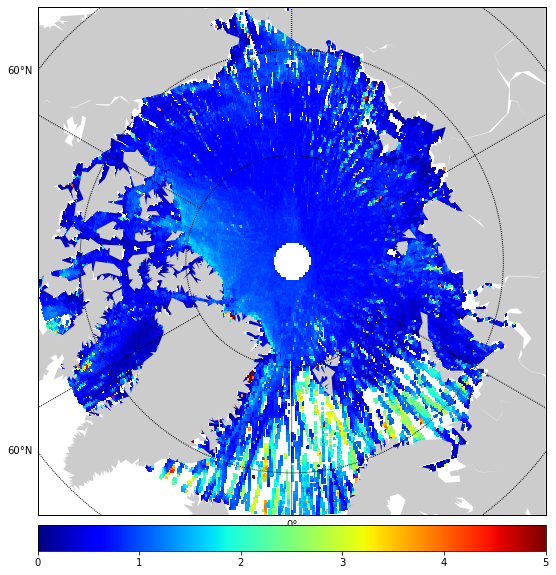

In [32]:
plt.figure(figsize=(10, 10))
is_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')
is_m.pcolormesh(is_x_map, is_y_map, data=is_mean_grid, cmap=plt.cm.jet,vmin=0, vmax=5,latlon = True)
is_m.colorbar(location='bottom')
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
# plt.title("is2 SWH  "+ year+ month)
plt.show()
plt.close()

# 对比hy与cryosat交叉点


In [93]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_cy_grid = hy_mean_grid - cy_mean_grid
hy_cy_diff_grid = np.argwhere(np.isnan(hy_cy_grid)!= True)

In [94]:
hy_cy_diff_grid.shape

(1686, 2)

In [95]:
cy_time_dict = dict(cy_siral.coincident_time_log(cy_df,value='swh_ocean_01_ku'))
hy_time_dict = dict(hy_alt.coincident_time_log(hy_df,value='swh_ku'))


In [118]:
# 创建一个用来存储点对的list
hy_cy_coincident_list = []
hy_cy_time_list = []
for i in range(hy_cy_diff_grid.shape[0]): 
    diff_x = hy_cy_diff_grid[i][0]
    diff_y = hy_cy_diff_grid[i][1]
    if diff_y>(hy_alt.nlat / 2):
        diff_y -= hy_alt.nlat
    key = str(diff_x) + '+' + str(diff_y)
    
    for cy_time_key in cy_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            hy_cy_time_list.append(np.abs(hy_time_key - cy_time_key))
            hy_cy_time_list.append(key)
            
            if np.abs(hy_time_key - cy_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(cy_time_key)
                coincident_value.append(cy_time_dict[key][cy_time_key])
                hy_cy_coincident_list.append(coincident_value)


In [117]:
time_window = 3600

In [119]:
hy_cy_df = pd.DataFrame(hy_cy_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])

hy_cy_df['hy_time_round'] = ((hy_cy_df['hy_time'].astype(np.float))/time_window).astype(np.int)

hy_cy_df['other_time_round'] = ((hy_cy_df['other_time'].astype(np.float))/time_window).astype(np.int)

In [120]:
hy_cy_df['diff'] = hy_cy_df['hy_value'] - hy_cy_df['other_value']

In [121]:
hy_cy_df

,ij,hy_time,hy_value,other_time,other_value,hy_time_round,other_time_round,diff
0,340+3,6.098428e+08,0.954,6.098447e+08,0.886,169400,169401,0.068
1,340+3,6.098428e+08,0.867,6.098447e+08,0.886,169400,169401,-0.019
2,340+3,6.098428e+08,0.960,6.098447e+08,0.886,169400,169401,0.074
3,340+3,6.098428e+08,0.954,6.098447e+08,0.793,169400,169401,0.161
4,340+3,6.098428e+08,0.867,6.098447e+08,0.793,169400,169401,0.074
...,...,...,...,...,...,...,...,...
62,348+5,6.091534e+08,4.336,6.091541e+08,5.368,169209,169209,-1.032
63,348+5,6.091534e+08,4.751,6.091541e+08,5.368,169209,169209,-0.617
64,348+5,6.091534e+08,4.475,6.091541e+08,5.102,169209,169209,-0.627
65,348+5,6.091534e+08,4.336,6.091541e+08,5.102,169209,169209,-0.766


In [126]:
hy_cy_mean_df = hy_cy_df.groupby(['ij','hy_time_round','other_time_round']).mean()

hy_cy_mean_df['diff'] = hy_cy_mean_df['hy_value'] - hy_cy_mean_df['other_value']


In [127]:
hy_cy_mean_df

,,,hy_time,hy_value,other_time,other_value,diff
ij,hy_time_round,other_time_round,,,,,
340+3,169400,169401,6.098428e+08,0.927000,6.098447e+08,0.792500,0.134500
341+3,169400,169401,6.098428e+08,0.899000,6.098447e+08,0.597500,0.301500
341+9,169160,169161,6.089779e+08,1.772000,6.089814e+08,1.869500,-0.097500
342+9,169160,169161,6.089779e+08,1.951000,6.089814e+08,1.774000,0.177000
344+4,169305,169305,6.094981e+08,0.986000,6.094994e+08,0.868250,0.117750
345+10,169064,169065,6.086332e+08,2.510500,6.086361e+08,2.872667,-0.362167
345+4,169305,169305,6.094981e+08,0.933333,6.094994e+08,0.868000,0.065333
345+9,169064,169065,6.086332e+08,2.308500,6.086361e+08,2.430000,-0.121500
348+5,169209,169209,6.091534e+08,4.520667,6.091541e+08,4.854250,-0.333583


In [124]:
hy_cy_mean_df = hy_cy_mean_df.drop(hy_cy_mean_df[hy_cy_mean_df.hy_value > hy_cy_mean_df['diff'].std() * 5 ].index)
hy_cy_mean_df = hy_cy_mean_df.drop(hy_cy_mean_df[hy_cy_mean_df.other_value > hy_cy_mean_df['diff'].std() * 5 ].index)

Text(0.5, 1.0, "['2019']['04']HY & CY SWH")

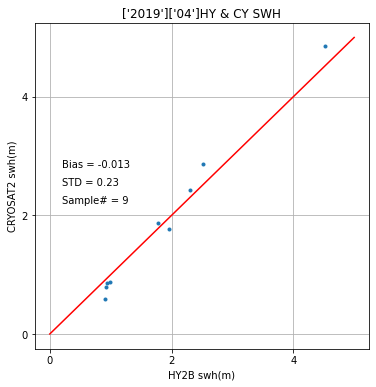

In [128]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_cy_mean_df['hy_value'], hy_cy_mean_df['other_value'], marker='.')
plt.plot(np.linspace(0,5),np.linspace(0,5),color='r')
x_tick = range(0,5,2)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(0.2, 2.8, 'Bias = '+str(round(hy_cy_mean_df['diff'].mean(), 3)))
plt.text(0.2, 2.5, 'STD = '+str(round(hy_cy_mean_df['diff'].std(), 3)))
plt.text(0.2,2.2,'Sample# = ' + str(hy_cy_mean_df.shape[0]))
plt.xlabel('HY2B ' + 'swh' + '(m)')
plt.ylabel('CRYOSAT2 ' + 'swh' + '(m)')
plt.title(str(years) + str(months) + 'HY & CY SWH' )
# plt.savefig(r'output/'+'2019-2020'+ str(months)  +'HY & CY' + 'swh' +' '+ 'scatter_plot.jpg')

# HY和CRYOSAT2交叉点在图像上绘制出来

In [133]:
hy_cy_draw_df = hy_cy_df.groupby(['ij']).mean()

In [134]:
hy_cy_draw_df

,hy_time,hy_value,other_time,other_value,hy_time_round,other_time_round,diff
ij,,,,,,,
340+3,6.098428e+08,0.927000,6.098447e+08,0.792500,169400,169401,0.134500
341+3,6.098428e+08,0.899000,6.098447e+08,0.597500,169400,169401,0.301500
341+9,6.089779e+08,1.772000,6.089814e+08,1.869500,169160,169161,-0.097500
342+9,6.089779e+08,1.951000,6.089814e+08,1.774000,169160,169161,0.177000
344+4,6.094981e+08,0.986000,6.094994e+08,0.868250,169305,169305,0.117750
345+10,6.086332e+08,2.510500,6.086361e+08,2.872667,169064,169065,-0.362167
345+4,6.094981e+08,0.933333,6.094994e+08,0.868000,169305,169305,0.065333
345+9,6.086332e+08,2.308500,6.086361e+08,2.430000,169064,169065,-0.121500
348+5,6.091534e+08,4.520667,6.091541e+08,4.854250,169209,169209,-0.333583


In [135]:
hy_cy_draw_diff_grid = hy_alt.get_nan_grid(hy_alt.nlat, hy_alt.nlon)
for i,index in enumerate(hy_cy_draw_df.index):
    hy_cy_draw_diff_grid[int(index.split('+')[0])][int(index.split('+')[1])] = hy_cy_draw_df.loc[hy_cy_draw_df.index[i]]['diff']


<ipython-input-136-b3ceb2e79bdd>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = cy_m.pcolormesh(cy_x_map, cy_y_map, data=hy_cy_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=1, vmin = -1)


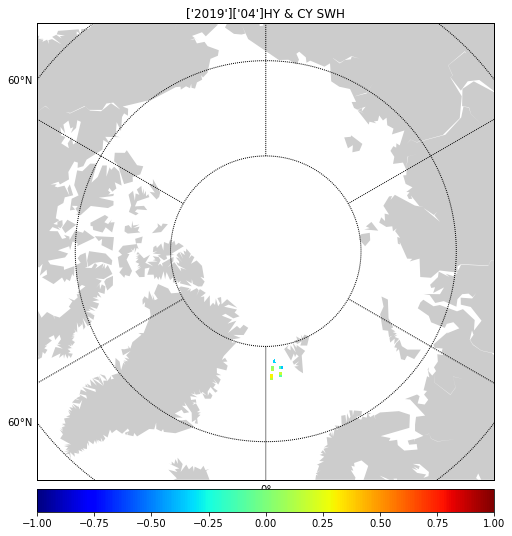

In [136]:
plt.figure(figsize=(9, 9))
cy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')

h = cy_m.pcolormesh(cy_x_map, cy_y_map, data=hy_cy_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=1, vmin = -1)

cy_m.colorbar(location='bottom')
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title(str(years) + str(months) + 'HY & CY SWH' )
# plt.savefig(r'output/'+'all/'+'2019-2020' +  str(months) +'HY & CY' + 'swh' + '.jpg')
plt.show()
plt.close()

# 对比hy与icesat交叉点


In [32]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_is_grid = hy_mean_grid - is_mean_grid
hy_is_diff_grid = np.argwhere(np.isnan(hy_is_grid)!= True)


In [ ]:

is_time_dict = dict(is_atlas.coincident_time_log(is_df,value='swh'))


In [ ]:
# 创建一个用来存储点对的list
hy_is_coincident_list = []
hy_is_time_list = []
for i in range(hy_is_diff_grid.shape[0]): 
    diff_x = hy_is_diff_grid[i][0]
    diff_y = hy_is_diff_grid[i][1]
    if diff_y>(hy_alt.nlat / 2):
        diff_y -= hy_alt.nlat
    key = str(diff_x) + '+' + str(diff_y)
    
    for is_time_key in is_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            hy_is_time_list.append(np.abs(hy_time_key - is_time_key))
            hy_is_time_list.append(key)
            
            if np.abs(hy_time_key - is_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(is_time_key)
                coincident_value.append(is_time_dict[key][is_time_key])
                hy_is_coincident_list.append(coincident_value)

In [ ]:

hy_is_df = pd.DataFrame(hy_is_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])

hy_is_df['hy_time_round'] = ((hy_is_df['hy_time'].astype(np.float))/time_window).astype(np.int)

hy_is_df['other_time_round'] = ((hy_is_df['other_time'].astype(np.float))/time_window).astype(np.int)

In [ ]:

hy_is_mean_df = hy_is_df.groupby(['ij','hy_time_round','other_time_round']).mean()

hy_is_mean_df['diff'] = hy_is_mean_df['hy_value'] - hy_is_mean_df['other_value']


In [ ]:
hy_is_mean_df = hy_is_mean_df.drop(hy_is_mean_df[hy_is_mean_df.hy_value > hy_is_mean_df['diff'].std() * 5 ].index)
hy_is_mean_df = hy_is_mean_df.drop(hy_is_mean_df[hy_is_mean_df.other_value > hy_is_mean_df['diff'].std() * 5 ].index)

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(hy_is_mean_df['hy_value'], hy_is_mean_df['other_value'], marker='.')
plt.plot(np.linspace(0,4),np.linspace(0,4),color='r')
x_tick = range(0,5,1)
plt.xticks(x_tick)
plt.yticks(x_tick)
plt.grid(True)
plt.text(0.5, 2.8, 'Bias = '+str(round(hy_is_mean_df['diff'].mean(), 3)))
plt.text(0.5, 2.5, 'STD = '+str(round(hy_is_mean_df['diff'].std(), 3)))
plt.text(0.5,2.2,'Sample# = ' + str(hy_is_mean_df.shape[0]))
plt.xlabel('HY2B ' + 'swh' + '(m)')
plt.ylabel('ICESAT2 ' + 'swh' + '(m)')
plt.title(str(years) + str(months) + 'HY & IS SWH' )

# plt.savefig(r'output/'+'2019-2020' +  str(months) +'HY & IS' + 'swh' +' '+ 'scatter_plot.jpg')

# HY和IS交叉点在图像上绘制出来

In [ ]:
hy_is_draw_diff_grid = hy_alt.get_nan_grid(hy_alt.nlat, hy_alt.nlon)
for i,index in enumerate(hy_is_mean_df.index):
    hy_is_draw_diff_grid[int(index[0].split('+')[0])][int(index[0].split('+')[1])] = hy_is_mean_df.loc[hy_is_mean_df.index[i]]['diff']


In [ ]:
plt.figure(figsize=(9, 9))
is_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=0, resolution='c')

h = is_m.pcolormesh(is_x_map, is_y_map, data=hy_is_draw_diff_grid, cmap=plt.cm.jet, latlon=True, vmax=1, vmin = -1)

is_m.colorbar(location='bottom')
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title(str(years) + str(months) + 'HY & IS SWH' )
plt.savefig(r'output/'+'all/'+'2019-2020' +  str(months) +'HY & IS' + 'swh' + '.jpg')
plt.show()
plt.close()

# 计算交叉点最多的日期

In [ ]:
import datetime
def conver_time(julian_time):
    '''
    将从'2000-01-01 00:00:00 开始的JulianDay 转换为%Y-%m-%d %H:%M:%S 格式的时间
    '''
    strTime = '2000-01-01 00:00:00'
    startTime = datetime.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S") 
    Time = (startTime + datetime.timedelta(seconds=julian_time)).strftime("%Y-%m-%d %H:%M:%S")
    return Time


    

In [204]:
hy_is_mean_df['hy_day'] = (hy_is_mean_df['hy_time']/86400).astype(np.int)
hy_is_mean_df['other_day'] = (hy_is_mean_df['other_time']/86400).astype(np.int)

hy_cy_mean_df['hy_day'] = (hy_cy_mean_df['hy_time']/86400).astype(np.int)
hy_cy_mean_df['other_day'] = (hy_cy_mean_df['other_time']/86400).astype(np.int)

In [206]:
# 统计重合点最多的日期
hy_is_top_num_day = hy_is_mean_df['hy_day'].value_counts().index[0]

hy_cy_top_num_day = hy_cy_mean_df['hy_day'].value_counts().index[0]

In [208]:
hy_cy_mean_df['hy_format_time'] = hy_cy_mean_df['hy_time'].apply(conver_time)
hy_cy_mean_df['other_format_time'] = hy_cy_mean_df['other_time'].apply(conver_time)

hy_is_mean_df['hy_format_time'] = hy_is_mean_df['hy_time'].apply(conver_time)
hy_is_mean_df['other_format_time'] = hy_is_mean_df['other_time'].apply(conver_time)

In [218]:
hy_cy_one_day_df = hy_cy_mean_df[hy_cy_mean_df['hy_day'] == hy_cy_top_num_day][['hy_format_time','other_format_time','hy_value','other_value','diff']]

hy_is_one_day_df = hy_is_mean_df[hy_is_mean_df['hy_day'] == hy_is_top_num_day][['hy_format_time','other_format_time','hy_value','other_value','diff']]